In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [27]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datetime import date, datetime

In [28]:
#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0.01
SCALING_CONSTANT = 10000

In [29]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
print(options.columns)

Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')


In [30]:
option_expiry = 20170112
trading_date = '2017-01-04'

In [31]:
pd.set_option('display.max_columns', None)
dataset = options.loc[(options['LastTradingDay'] == option_expiry)& (options['WholeDayVolume']> 0) & (options['Date'] == trading_date)][['StrikePrice', 'Putcall', 'SettlementPrice']]#[['WholeDayClose', 'SettlementPrice']]
dataset[['StrikePrice', 
         
         'SettlementPrice']] = dataset[['StrikePrice', 'SettlementPrice']].transform(lambda x : x/SCALING_CONSTANT)
dataset['Putcall'] = dataset['Putcall'].transform(lambda x : False if x==1 else True)

In [32]:
train_df, test_df = train_test_split(dataset, test_size = 0.2)

In [51]:
len(train_df)

60

In [52]:
len(test_df)

15

In [33]:
from torch.utils.data import DataLoader

prices_and_strikes = [ (train_df['SettlementPrice'].iloc[i], train_df['StrikePrice'].iloc[i], train_df['Putcall'].iloc[i]) for i in range(len(train_df))]
train_set_size = len(prices_and_strikes)
batch_size = train_set_size
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)

In [34]:
test_prices_and_strikes = [ (test_df['SettlementPrice'].iloc[i], test_df['StrikePrice'].iloc[i], test_df['Putcall'].iloc[i]) for i in range(len(test_df))]
test_set_size = len(test_prices_and_strikes)
batch_size = len(test_prices_and_strikes)
test_dataloader = DataLoader(test_prices_and_strikes , batch_size=batch_size, shuffle = True)

In [35]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
        
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
#model = BaselineNet().to(device)
model_eq = BaselineNet().to(device)

Using cpu device


In [37]:
class OptionLoss(nn.Module):
    def __init__(self):
        super(OptionLoss,self).__init__()
        self.huber = nn.HuberLoss()
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        mc_steps = len(coordinates)
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        density = 1/INTERVAL_LENGTH 
        mc_prices = torch.stack([ torch.sum(payoff(j) * outputs / density)/mc_steps for j in range(len(labels))])
        
        return self.huber(mc_prices/labels, torch.ones_like(labels))


In [38]:
class AbsolutePercentageLoss(nn.Module):
    def __init__(self):
        super(AbsolutePercentageLoss, self).__init__()
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        mc_steps = len(coordinates)
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        densities = 1/INTERVAL_LENGTH 
        for j in range(len(labels)):
          mc_price = payoff(j) * outputs / densities
          #print("true price " + str(labels[j]) )
          #print("predicted price " + str(mc_price.sum() / mc_steps) )
          #print("absolute difference " + str(torch.abs(labels[j] -  mc_price.sum() / mc_steps)))
          print("delta (percentage of true price)" + str(torch.abs(labels[j] -  mc_price.sum() / mc_steps)/labels[j]) )
          loss += torch.abs(labels[j] -  mc_price.sum() / mc_steps)/labels[j]
        return loss  
            

In [39]:
test_error = AbsolutePercentageLoss()

In [40]:
optimizer_eq = torch.optim.Adam(model_eq.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss()
test_error = AbsolutePercentageLoss()

In [41]:
def train(input_model, optimizer, loss_fn, C1, C2, target_dataloader, equidistant_window=False):
    loss_history = []
    for epoch in tqdm(range(int(396*C1))):
        avg_loss = 0
        for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
            if epoch < 100 * C1:
                mc_steps = int(128*C2)
            elif epoch < 300 * C1:
                mc_steps = int(256*C2)
                if epoch == int(100* C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density1.png")
                    plt.close()
            elif epoch < 350 * C1:
                #change to relative mse maybe
                mc_steps = int(512*C2)
                if epoch == int(300 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density2.png")
                    plt.close()
            elif epoch < 375 * C1:
                mc_steps = int(1024*C2)
                if epoch == int(350 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density3.png")
                    plt.close()
            elif epoch < 387 * C1:
                mc_steps = int(2048*C2)
                if epoch == int(375 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density4.png")
                
            elif epoch < 393*C1:
                mc_steps = int(4096*C2)
                if epoch == int(387 * C1):
                    x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
                    p_eq = input_model(x)
                    plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
                    plt.savefig("/kaggle/working/density5.png")
                    plt.close()
            else:
                mc_steps = int(8192*C2)
            
            
            if equidistant_window:
                coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*mc_steps),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*mc_steps),num=mc_steps)+np.random.uniform(low=-INTERVAL_LENGTH/(2*mc_steps),high=INTERVAL_LENGTH/(2*mc_steps),size=mc_steps)
                coordinates = coordinates.reshape(  -1, 1)
                X = torch.tensor(coordinates, dtype = torch.float32).to(device)
                

            else:
                X = torch.zeros(mc_steps, 1).to(device)
                X.uniform_(START_UNIF, INTERVAL_LENGTH)



            #print(X)
            #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
            #print(X)
            pred = input_model(X)
            loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(input_model.parameters(), 1e-1)
            optimizer.step()
            avg_loss += loss
        loss_history.append(float(avg_loss/(batch + 1)))
    return loss_history

In [42]:
def test(model, loss_fn, test_dataloader, mc_steps = 4096):
    # only one single batch used
    for batch, (target_prices, strike_prices, is_call) in enumerate(test_dataloader):
        coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*mc_steps),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*mc_steps),num=mc_steps)+np.random.uniform(low=-INTERVAL_LENGTH/(2*mc_steps),high=INTERVAL_LENGTH/(2*mc_steps),size=mc_steps)
        coordinates = coordinates.reshape(  -1, 1)
        X = torch.tensor(coordinates, dtype = torch.float32).to(device)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
    return loss/len(test_dataloader)


In [43]:
loss_history_eq = train(model_eq, optimizer_eq, loss_fn, 20, 2, target_dataloader, equidistant_window = True)

100%|██████████| 7920/7920 [15:27<00:00,  8.54it/s]


In [44]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p_eq = model_eq(x)
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
plt.savefig("/kaggle/working/final_density.png")
plt.close()

In [45]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p_eq = model_eq(x)
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)
plt.yscale("log")
plt.savefig("/kaggle/working/logdensity.png")
plt.close()

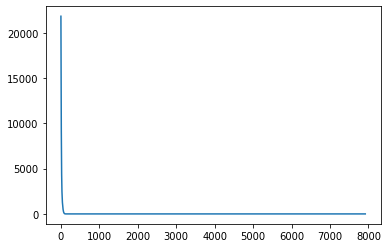

In [46]:
plt.plot(range(len(loss_history_eq)), loss_history_eq)

In [47]:
plt.plot(range(len(loss_history_eq)), loss_history_eq)
plt.yscale("log")
plt.savefig("/kaggle/working/loghistory.png")
plt.close()

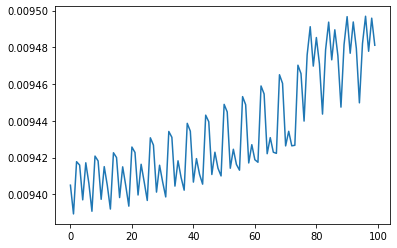

In [48]:
running_loss_average_eq = uniform_filter1d(loss_history_eq, size=50)
plt.plot(range(len(running_loss_average_eq[-100:])), running_loss_average_eq[-100:])

In [49]:
total_error = test(model_eq, test_error, test_dataloader)
average_error = total_error.detach().numpy() / len(test_prices_and_strikes)
print(average_error)
print(len(test_prices_and_strikes))

delta (percentage of true price)tensor(0.0806, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0089, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.1237, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.2455, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0619, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0066, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0489, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0667, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0150, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0575, dtype=torch.float64, grad_fn=<DivBackward0>)
delta (percentage of true price)tensor(0.0450, dtype=torch.float64, grad_fn=<Div

In [50]:
x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
p = np.array(model(x).detach())
print(np.argmax(p)*0.01*SCALING_CONSTANT)

NameError: name 'model' is not defined